# Complete Demo

In [5]:
from hostphot.utils import plot_fits, plot_image
from hostphot.cutouts import download_images
from hostphot.processing import coadd_images
from hostphot.processing import masking
from hostphot.photometry import global_photometry as gp

from astropy.utils.data import clear_download_cache
clear_download_cache()  # saves space in your machine

In [2]:
name = 'SN2002fk'

ra, dec = 50.52379, -15.40089
host_ra, host_dec = 50.527333, -15.400056
z = 0.0075

Host coordinates are used to center the image cutouts and selecting the host.

## Cutouts

In [3]:
surveys = ['GALEX', 'PanSTARRS', '2MASS', 'WISE']

for survey in surveys:
    print(survey)
    download_images(name, 
                    host_ra, 
                    host_dec, 
                    survey=survey, 
                    overwrite=False,  # saves some time when rerunning
                    save_input=True,  # to be able to replicate the results - True by default
                   )

GALEX
PanSTARRS
2MASS
WISE


## Coadds

In [6]:
coadd_images(name, filters='riz', survey='PanSTARRS')

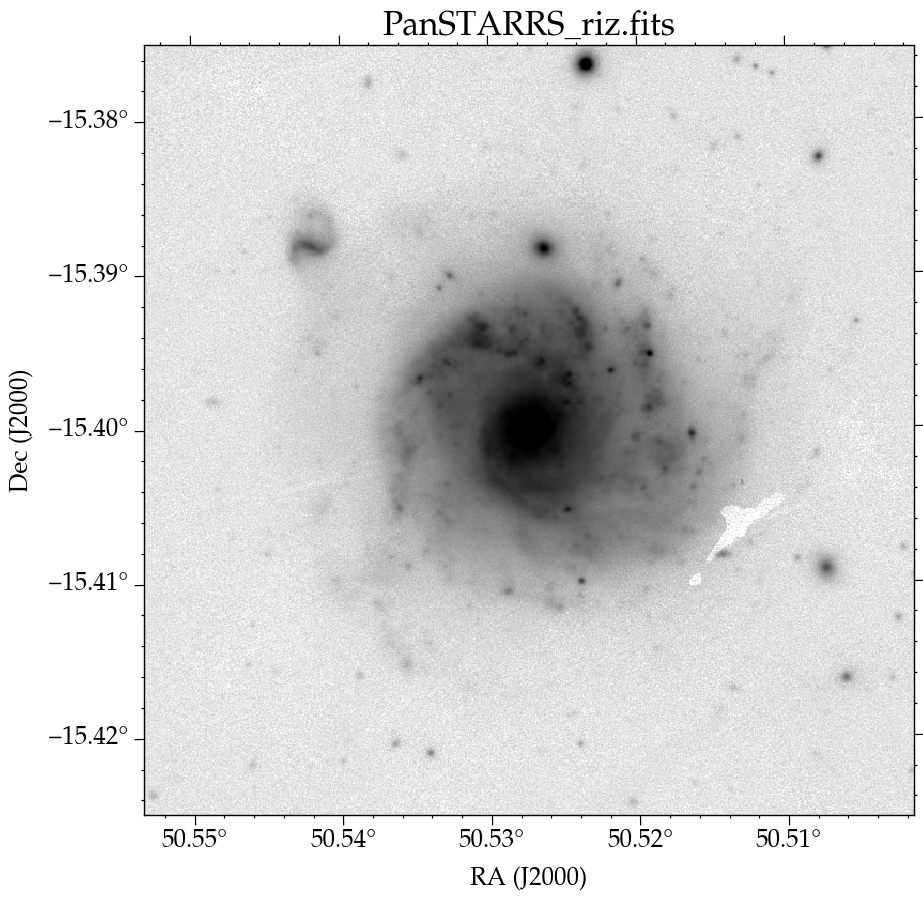

In [7]:
plot_fits("images/SN2002fk/PanSTARRS/PanSTARRS_riz.fits")

## Masking

First the coadd to see how it looks

In [8]:
masking.create_mask(name, 
                    host_ra, 
                    host_dec, 
                    filt='riz', 
                    survey="PanSTARRS",
                    # masking parameters
                    threshold=12,  # sigmas above bkg to detect sources
                    sigma=6,  # width of the Gaussian kernel
                    r=4,  # to scale the size of the masks
                    # other parameters
                    ra=ra, dec=dec,  # to plot the SN position
                    save_plots=True,  # False by default as it takes some time to create the figure
                    save_mask_params=True,  # to use the output on the other images - False by default
                    save_input=True,  # True by default
                   )

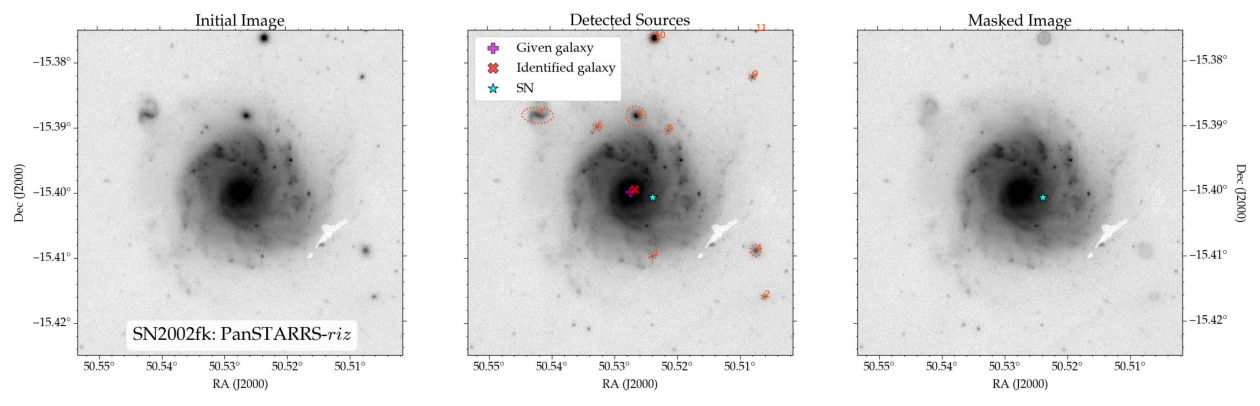

In [9]:
plot_image("images/SN2002fk/PanSTARRS/PanSTARRS_riz_masked.jpg")

Compared to previous versions (< 3.0.0), the "aperture" of the __host galaxy is not plotted anymore__ to avoid confusion as it is not the final aperture.

## Applying the mask

Let's apply the same mask on every filter from every survey.

In [10]:
from hostphot.surveys_utils import get_survey_filters

for survey in surveys:
    filters = get_survey_filters(survey)
    for filt in filters:
        try:
            masking.create_mask(name, 
                                host_ra, 
                                host_dec, 
                                filt=filt, 
                                survey=survey,
                                # where to get the mask from
                                ref_filt="riz",
                                ref_survey="PanSTARRS",
                                # let's not waste space and time
                                save_plots=False,  # no need to store these plots as we have the reference
                                save_mask_params=False,  
                                save_input=False,  
                               )
        except Exception as exc:
            print(f"{survey}-{filt}: {exc}")

## Global Aperture

The __coadd__ is used as a __reference__ for the aperture used on the rest of the images.

In [11]:
_ = gp.extract_aperture(name, 
                        host_ra, 
                        host_dec, 
                        filt='riz', 
                        survey='PanSTARRS', 
                        ra=ra, 
                        dec=dec, 
                        use_mask=True,  # use the masked image just created
                        optimize_kronrad=True,  # are we "optimising" for DR3? We did for DR2
                        eps=0.001,  # fractional changes in flux when "optimising"
                        gal_dist_thresh=-1,  # how far to go until the host galaxy is found 
                        save_aperture_params=True,  # to use the output on the other images - True by default
                        save_plots=True, # to check the results - True by default
                       )

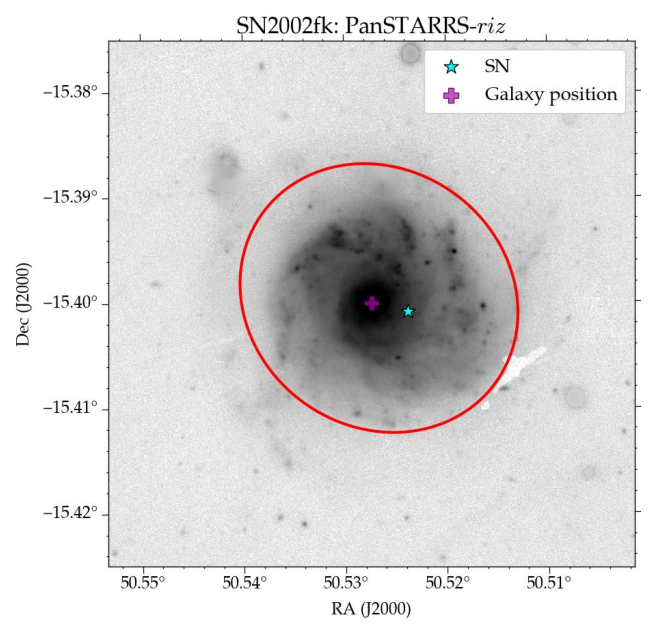

In [12]:
plot_image("images/SN2002fk/PanSTARRS/global_PanSTARRS_riz.jpg")

## Global Photometry

In [13]:
for survey in surveys:
    gp.multi_band_phot(name, 
                       host_ra, 
                       host_dec,
                       survey=survey, 
                       ra=ra, 
                       dec=dec,
                       use_mask=True, 
                       correct_extinction=False,  # no extinction for now
                       # we tell HostPhot to use the "reference" aperture
                       common_aperture=True, 
                       ref_survey='PanSTARRS', 
                       ref_filt='riz',
                       # let's store only some of the results
                       save_plots=True, 
                       save_results=True,  # stores the photometry in a CSV file
                       save_aperture_params=False,
                       raise_exception=False  # in case something goes wrong
                      )

## SED

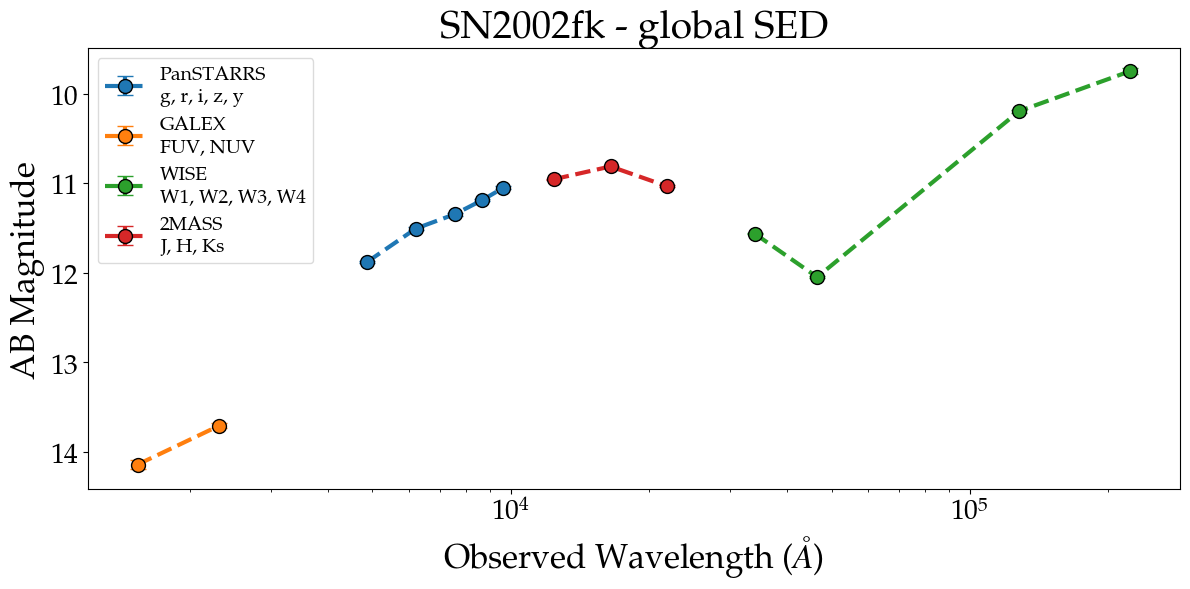

In [14]:
from hostphot.photometry import sed_plotting

name = 'SN2002fk'
sed_plotting.plot_sed(name)